In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##### 부트스트래핑 (bootstrapping)

In [4]:
# 가상의 데이터 생성 (w0 = 0, w1 = 42.3855)
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                             coef=True, random_state=0)

coef

array(42.38550485581797)

In [5]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [6]:
# 앞서 생성한 가상의 데이터를 기반으로 회귀분석 진행 
# -> coef에 차이 발생 (42.3855 vs 42.8533)
result.params

const    -1.628364
X1       42.853356
dtype: float64

In [7]:
# 1000개의 데이터를 뽑는 부트스트래핑 진행 (1000번)

N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)

for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

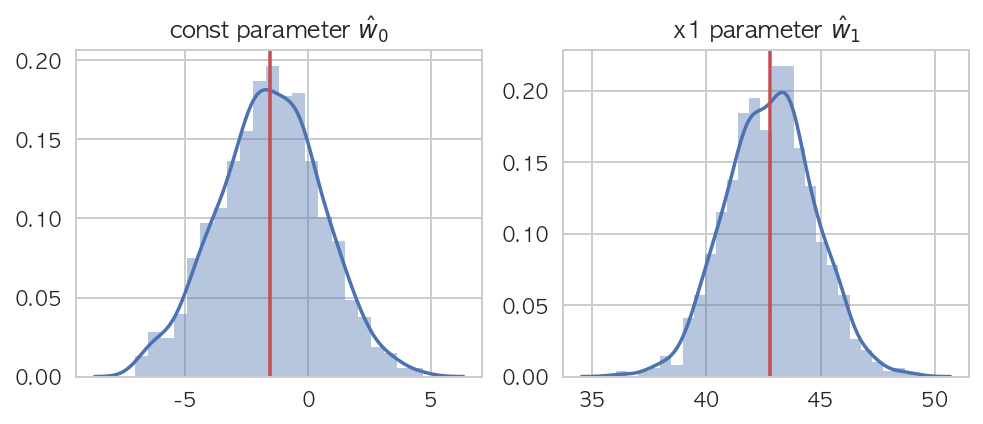

In [8]:
# 전체 가중치 집합을 히스토그램으로 나타내기
plt.figure(figsize=(8,3))

ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter $\hat{w}_0$")

ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter $\hat{w}_1$")
plt.show()

In [9]:
params_c.mean(), params_c.std()

(-1.5597507532338666, 2.1044161721037775)

In [10]:
params_x1.mean(), params_x1.std()

(42.807102147181006, 1.9268989645840082)

In [12]:
 #OLS 리포트와 비교 : 부트스트래핑 결과와 유사함 :)

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        23:06:34   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

##### 확률론적 선형회귀모형

In [ ]:
### 잔차의 분포

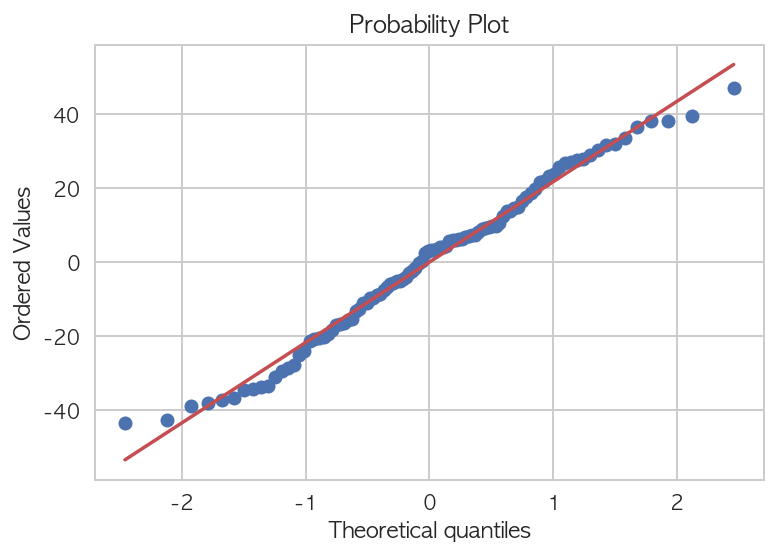

In [13]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [14]:
# 잔차의 정규성 검정 - omni_norm검정
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s : %6.3f" % xi)

Chi^2        :  3.523
P-value      :  0.172


In [16]:
# 잔차의 정규성 검정 - Jarque-Bera검정
test = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'kurtosis'],test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
kurtosis    :  2.312


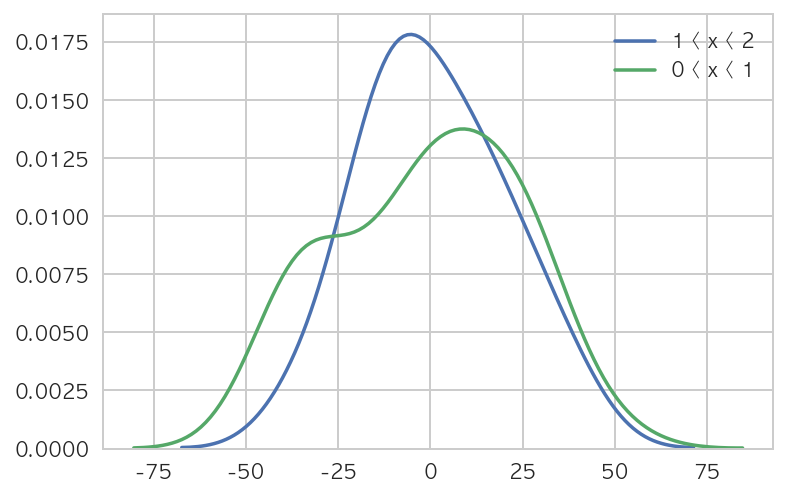

In [17]:
# 잔차의 기대값은 x에 상관없이 0

sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

##### 단일 계수 t-검정

In [18]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        01:09:52   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

In [24]:
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104
